# Contour Matvec for Square Root Fermi-Dirac

In [1]:
# Load modules 

import os 
import sys 

print(os.getcwd()) # print the current working directory
sys.path.append(os.path.join(os.getcwd(), '..')) # add the root directory to the path

from src import * # import everything from the src folder

/home/jovyan/project/MirrorDescent-DFT/drafts



We use this notebook to show the contour matvec for square root fermi dirac function in `jax`. In detail, for a matrix $H$, we show how to compute the matvec of: 
$$
f_{\beta}^{1/2}(H) \coloneqq \sqrt{\frac{1}{1+e^{\beta H}}}.
$$

The main idea is to use the Cauchy integral on the holomorphic extension of $f_{\beta}^{1/2}(x)$ i.e., 
$$
f_{\beta}^{1/2}(x) = \int_{\Gamma} \frac{g_{\beta}^{1/2} (s)}{s - x} \, \mathrm{d} s \approx \sum_{i=1}^{N_{\text{poles}}} \frac{g_{\beta}^{1/2}(s_i) w_i}{(s_i - x)},  
$$
where 

- $g_{\beta}^{1/2}(x)$ is a holomorphic extension of $f_{\beta}^{1/2}(x)$ from $\mathbb{R}$ to a subset in $\mathbb{C}$;
- $\Gamma$ is a good contour around $x$;
- $(s_i)_{i=1}^{N_{\text{poles}}}$ are some points in this contour.

With this, the contour matvec will become: 
$$
f_{\beta}^{1/2}(H) \cdot v \approx \sum_{i=1}^{N_{\text{poles}}} g_{\beta}^{1/2}(s_i) w_i  \cdot \Big \{ \big (s_i I  -  H \big)^{-1} \cdot v \Big \}.
$$

--- 

- Section 1: We introduce the holomorphic extension of $f_{\beta}^{1/2}$. 
- Section 2: We show how to pick shifts and weights from the contour.
- Section 3: We show how to do the inverse problem for each shift.
- Section 4: We use `vmap` and assembly all previous tools to compute the matvec.


## 1. holomorphic extension of $f_{\beta}^{1/2}$

The original Fermi-Dirac function is for $\mathbb{R}^n$ and defined as:
$$
f(x) \coloneqq \frac{1}{1+e^{x}}.
$$
We want to understand the square root of this $f$, which is: 
$$
g(x) \coloneqq f^{\frac{1}{2}}(x) = \sqrt{\frac{1}{1+e^x}}. 
$$
Now we extend this function to $\mathbb{C}^n$ and make it holomorphic in most regions we care. 

We implement this function as `complex_square_root_fermidirac`.

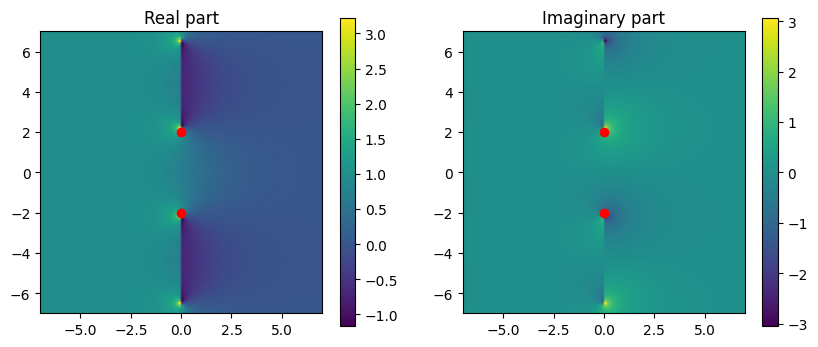

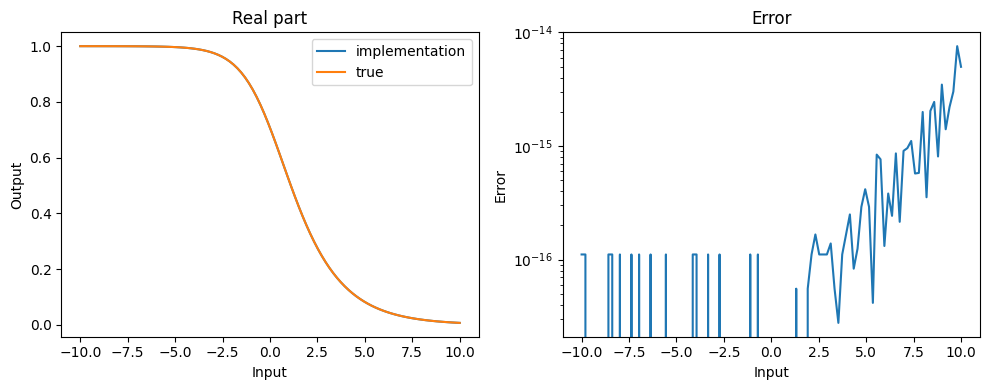

In [2]:
input = np.linspace(-10, 10, 100) + 1j*np.linspace(-10, 10, 100)[:, np.newaxis]
output = complex_square_root_fermi_dirac(input)
input_real = np.linspace(-10, 10, 100)
output_real = complex_square_root_fermi_dirac(input_real)
output_real = np.real(output_real)
true_output_real = np.sqrt(1/(1+np.exp(input_real)))

plt.figure(figsize=(10,4), dpi=100)
plt.subplot(1,2,1)
# plt.figure(figsize=(4,8), dpi=100)
plt.imshow(np.real(output), extent=(-7, 7, -7, 7))
plt.colorbar()
plt.scatter([0,0],[2,-2], color='red')
plt.title("Real part")
# plt.show()

plt.subplot(1,2,2)
# plt.figure(figsize=(8,8), dpi=100)
plt.imshow(np.imag(output), extent=(-7, 7, -7, 7))
plt.colorbar()
plt.scatter([0,0],[2,-2], color='red')
plt.title("Imaginary part")
plt.show()

plt.figure(figsize=(10,4), dpi=100)
plt.subplot(1,2,1)
plt.plot(input_real, output_real, label="implementation")
plt.plot(input_real, true_output_real, label="true")
plt.legend()
plt.title("Real part")
plt.xlabel("Input")
plt.ylabel("Output")

plt.subplot(1,2,2)
plt.semilogy(input_real, np.abs(output_real-true_output_real))
plt.title("Error")
plt.xlabel("Input")
plt.ylabel("Error")
plt.tight_layout()
plt.show()

# plt.show()

## 2. Contour poles generation

We mainly apply tools from Lin's [paper](https://arxiv.org/pdf/0906.1319) to generate countour poles and the corresponding weights.

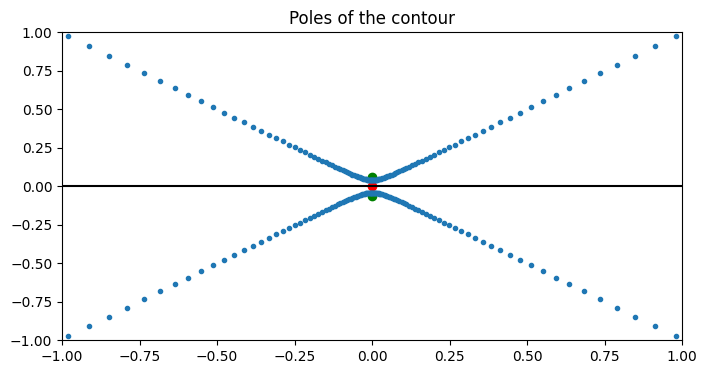

In [21]:
E_m = -10  # minimal energy
E_M = 10 # maximal energy
beta = 32 # inverse temperature
N = 100 # number of points

xi, w = gen_contour(E_m, E_M, beta, N, function='fermi_dirac')

plt.figure(figsize=(8,4), dpi=100)
plt.plot(np.hstack([xi.real,xi.real]), np.hstack([xi.imag, - xi.imag]),'.')
plt.hlines(y=0, xmin=E_m, xmax=E_M, colors='k')
plt.scatter([E_m, 0, E_M], [0, 0, 0], color='red')
plt.scatter([0,0],[2/beta,-2/beta], color='green') # 
plt.title('Poles of the contour')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

We can also check the scaling of the contour method. Actually, the approximation error decreases exponentially with respect to the number of poles.

In [22]:
from tqdm import tqdm

betas = [1,2,4,8,16,32,64]
Em = -1
EM = 400
mu = 0
Ns = np.linspace(1,30,30).astype(int)
errors = np.zeros((len(betas),len(Ns)))
x = np.linspace(-10,10,1000)
# print(Ns)
for i in tqdm(range(len(betas))):
    true_f = np.sqrt(1/(1+np.exp(betas[i]*(x-mu))))
    for j in range(len(Ns)):
        xi, w = gen_contour(Em, EM, betas[i], Ns[j], mu=mu, function='fermi_dirac')
        esti_f = contour_f(x,xi,w)
        errors[i,j] = np.mean(np.abs(true_f-esti_f))

100%|██████████| 7/7 [00:00<00:00,  8.90it/s]


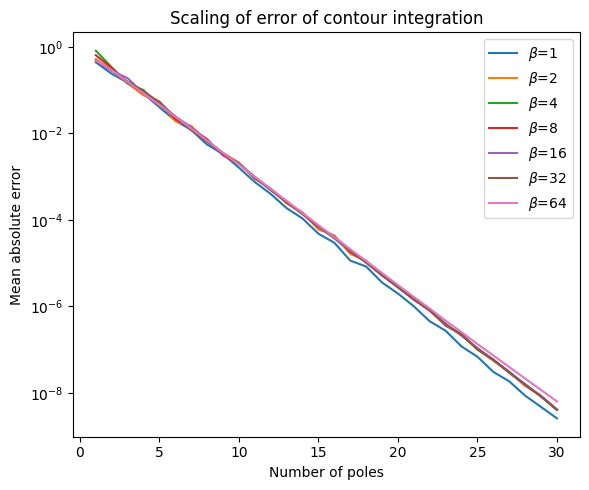

In [23]:
plt.figure(figsize=(6,5), dpi=100)
for i in range(len(betas)):
    plt.semilogy(Ns, errors[i,:], label=r'$\beta$='+str(betas[i]))
plt.legend()
plt.ylabel("Mean absolute error")
plt.xlabel("Number of poles")
plt.title("Scaling of error of contour integration")
plt.tight_layout()
plt.show()

## 3. Inverse problem

We will use GMRES or BiCGstab to solve this problems: 
$$
(s_i I  -  H \big)^{-1} \cdot v
$$

It's worth noticing that due to the special update of mirror descent, $H$ can be written as: 
$$
H = c_H K + \text{diag}^*(v_H),
$$
where $K$ is the planewave-type discretization of the $-\Delta$. In fact, $K$ can be written as $\mathcal{F} D \mathcal{F^*}$, where 
$$
D = \text{diag}^*(d_k), \quad d_k = \sum_{i=1}^d (2\pi k_i /L_i)^2, \quad k \in \hat{\mathcal{I}}.
$$
Hence, 
$$
(s_i I  -  H \big)^{-1} \cdot v = (s_i I - \text{diag}^*(v_H) -  c_H K \big)^{-1} \cdot v
$$
We need to implement two abstract linear maps to accelerate the problem solving:
- One for $\Big\{ \big [ s_i  I -  \text{diag}^*( v_H) \big] - c_H \cdot K \Big \} \cdot v$ 
- Another one for the preconditioner. We will consider the operation, $\big[  s_i  I  -   c_H \cdot K \big ]^{-1} \cdot v$


For the first one, we implement it as: 
$$
\Big\{ \big [ s_i  I -  \text{diag}^*( v_H) \big] -  c_H \cdot K \Big \} \cdot v = \mathcal{F} \cdot  ( s_i -  c_H \cdot D/2  ) \cdot \mathcal{F}^* \cdot v  -  v_H\odot v. 
$$


For the second one, we implement it as: 
$$
\Big\{ s_i  I  -  c_H \cdot K \Big \}^{-1} \cdot v = \mathcal{F} \cdot 1/ ( s_i  -  c_H \cdot D/2  ) \cdot \mathcal{F}^* \cdot v . 
$$

In [12]:
Ns = (21, 21, 21)
Ls = (1, 1, 1)
c_H = 1
v_H = jnp.ones(Ns[0]*Ns[1]*Ns[2]) 

D = genDiscretizedLaplacianEigenvalues(Ns, Ls)

v = jax.random.normal(jax.random.PRNGKey(0), (Ns[0]*Ns[1]*Ns[2], 10))
v = jnp.complex128(v)

shift = jnp.complex128(1j+2)

tol = 1e-6
tic()
u = shift_inv_system(c_H, v_H,  D, v, shift, tol)
toc()
tic()
u = shift_inv_system(c_H, v_H,  D, v, shift, tol)
toc()

temp_v = v_H[:, None] * u
u = jnp.fft.fftn(u.reshape([Ns[0], Ns[1], Ns[2], -1]), axes=[0, 1, 2])
u = jnp.multiply((shift - c_H *D)[:, :, :, None], u)
u = jnp.fft.ifftn(u, axes=[0, 1, 2]).reshape([Ns[0]*Ns[1]* Ns[2], -1])
u = u - temp_v

print(jnp.mean(jnp.abs(u - v)))

Elapsed time: 0.001309 seconds.
Elapsed time: 0.001389 seconds.
3.34190409729119e-08


## 4. Contour matvec

Now we can assembly everything. Here is the code to demonstrate the final scaling.

In [ ]:
N1, N2, N3 = 5, 5, 5
L1, L2, L3 = 2.0, 3.0, 4.0

Ns = (N1, N2, N3)
Ls = (L1, L2, L3)

D = genDiscretizedLaplacianEigenvalues(Ns, Ls)
K = genDiscretizedLaplacian(Ns, Ls)
v_H = jnp.ones(N1*N2*N3)
c_H = -1
H = c_H * K + jnp.diag(v_H) 

E_m = c_H * (jnp.max(D))- 1
E_M = c_H * (jnp.min(D))+ 1
print(E_m)
print(E_M)


betas = [1,2,4,8,16,32,64]
n_poless = np.linspace(1,60,60).astype(int)
errors = np.zeros([len(betas),len(n_poless)])

v = jnp.complex128(jax.random.normal(jax.random.PRNGKey(0), (N1*N2*N3, 1)))
w, V = jnp.linalg.eigh(H) 

for i in range(len(betas)):

    beta = betas[i]
    x = w*beta  
    w1 = complex_square_root_fermi_dirac(x)
    w1 = jnp.real(w1)
    square_f_beta_H = V @ jnp.diag(w1) @ V.T
    true_result = square_f_beta_H @ v
    true_result = jnp.real(true_result)


    for j in tqdm(range(len(n_poless))):

        n_poles = n_poless[j]
        shifts, weights = gen_contour(E_m, E_M, beta, n_poles, function='fermi_dirac')
        result = contour_matvec(c_H, v_H, D, v, 1e-12, shifts, weights)
        error = jnp.mean(jnp.abs(result - true_result))
        errors[i,j] = error.item()


-1.0
67.8939853851612


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 106.41it/s]


In [33]:
print(result[:10])
print(true_result[:10])

[[-3.20873189e-12]
 [ 8.00658151e-13]
 [ 2.80819465e-12]
 [-3.27319769e-13]
 [-2.20801502e-12]
 [-2.48336421e-12]
 [ 1.72592149e-12]
 [ 2.53594021e-12]
 [-1.22549193e-12]
 [-2.86199536e-12]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


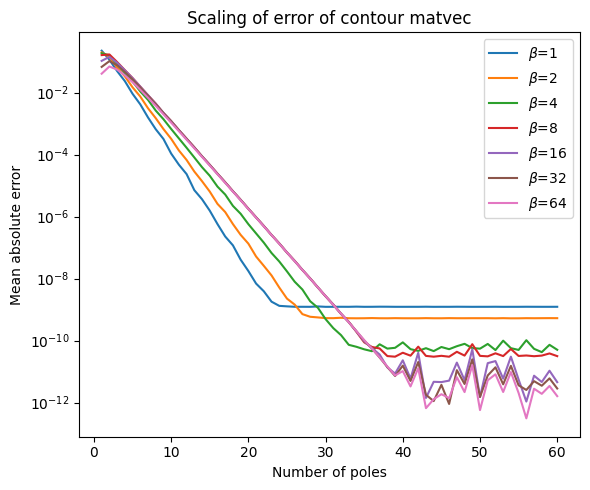

In [34]:
plt.figure(figsize=(6,5), dpi=100)
for i in range(len(betas)):
    plt.semilogy(n_poless, errors[i,:], label=r'$\beta$='+str(betas[i]))
plt.legend()
plt.ylabel("Mean absolute error")
plt.xlabel("Number of poles")
plt.title("Scaling of error of contour matvec")
plt.tight_layout()
plt.show()

In our contour generating function, we also have another choice of functions. This is the binary entropy of fermi dirac functions. This means we can also do the following matvec: 
$$
g(f_{\beta}(H)) v, \quad  \text{ where } g(X) = X \log X + (I-X) \log (I-X). 
$$

In [36]:
N1, N2, N3 = 5, 5, 5
L1, L2, L3 = 2.0, 3.0, 4.0

Ns = (N1, N2, N3)
Ls = (L1, L2, L3)

D = genDiscretizedLaplacianEigenvalues(Ns, Ls)
K = genDiscretizedLaplacian(Ns, Ls)
v_H = jnp.ones(N1*N2*N3)
c_H = -1
H = c_H * K + jnp.diag(v_H) 

E_m = c_H * (jnp.max(D))- 1
E_M = c_H * (jnp.min(D))+ 1
print(E_m)
print(E_M)


betas = [1,2,4,8,16,32,64]
n_poless = np.linspace(1,60,60).astype(int)
errors = np.zeros([len(betas),len(n_poless)])

v = jnp.complex128(jax.random.normal(jax.random.PRNGKey(0), (N1*N2*N3, 1)))
w, V = jnp.linalg.eigh(H) 

for i in range(len(betas)):

    beta = betas[i]
    x = np.clip(w * beta, -200, 200)

    # Use np.log1p for better numerical stability
    term1 = -np.log1p(np.exp(x)) / (1 + np.exp(x))
    term2 = -np.log1p(np.exp(-x)) / (1 + np.exp(-x))

    w1 = term1 + term2
    square_f_beta_H = V @ jnp.diag(w1) @ V.T
    true_result = square_f_beta_H @ v
    true_result = jnp.real(true_result)


    for j in tqdm(range(len(n_poless))):

        n_poles = n_poless[j]
        shifts, weights = gen_contour(E_m, E_M, beta, n_poles, function=None)
        weights = weights * complex_bin_entropy_fermi_dirac(shifts * beta)
        result = contour_matvec(c_H, v_H, D, v, 1e-12, shifts, weights)
        error = jnp.mean(jnp.abs(result - true_result))
        errors[i,j] = error.item()


-1.0
67.8939853851612


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 153.57it/s]


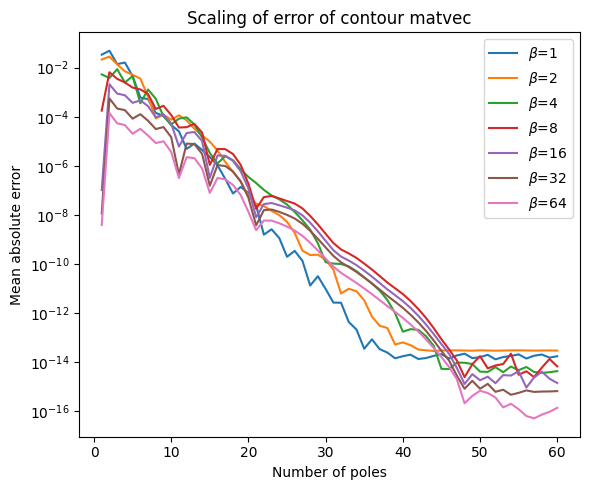

In [37]:
plt.figure(figsize=(6,5), dpi=100)
for i in range(len(betas)):
    plt.semilogy(n_poless, errors[i,:], label=r'$\beta$='+str(betas[i]))
plt.legend()
plt.ylabel("Mean absolute error")
plt.xlabel("Number of poles")
plt.title("Scaling of error of contour matvec")
plt.tight_layout()
plt.show()